In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

import src
from src.reload import deep_reload

In [3]:
filename = 'Outputs/entity_atlas.json'

entities = src.graph.graph_from_json(filename)

In [4]:
entities._node['place_0'],entities._node['station_0']

({'status': 1,
  'visited': 0,
  'name': 'San Fernando',
  'class': 'C1',
  'geoid': '0666140',
  'x': -118.436242283817,
  'y': 34.28865249013806,
  'type': 'place'},
 {'status': 1,
  'visited': 0,
  'x': -118.4898,
  'y': 34.010528,
  'n_dcfc': 2,
  'n_acl2': 12.0,
  'network': 'Non-Networked',
  'name': 'City of Santa Monica - Civic Parking Garage',
  'address': '333 Civic Center Dr',
  'city': 'Santa Monica',
  'state': 'CA',
  'zip': '90401',
  'access_code': 'public',
  'status_code': 'E',
  'type': 'station'})

In [5]:
places = [k for k, n in entities._node.items() if n['type'] == 'place']
stations = [k for k, n in entities._node.items() if n['type'] == 'station']

places = src.graph.subgraph(entities, places)
stations = src.graph.subgraph(entities, stations)

In [6]:
gdf_zones = gpd.read_file('Data/NGOD/Shapes/V2_Zones.shp')

gdf_zones['in_california'] = gdf_zones['V2ZONEID'].apply(lambda zid: 'CA' in zid)

gdf_zones_california = gdf_zones[gdf_zones['in_california']]

gdf_zones_california = gdf_zones_california.explode(drop = True)

In [8]:
atlas = src.graph.graph_from_json('Outputs/atlas.json')

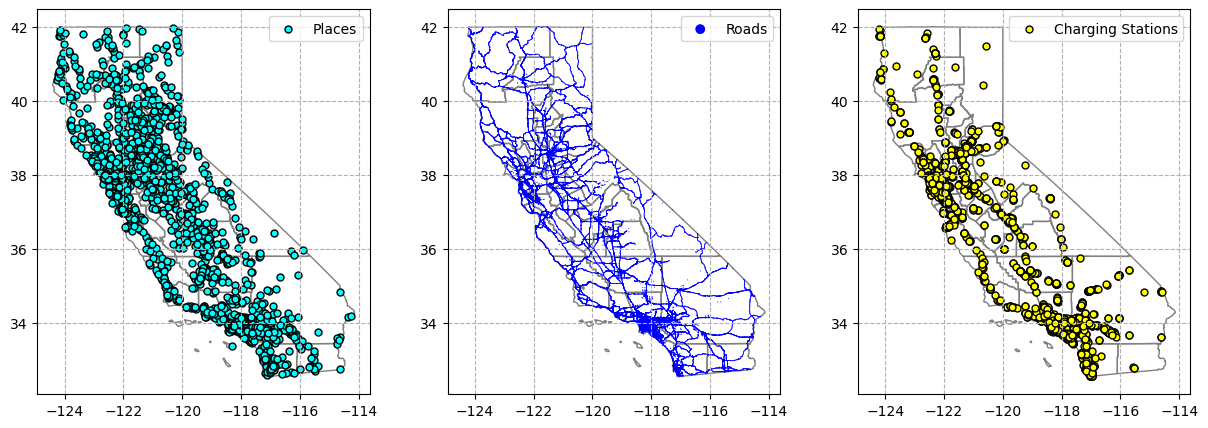

In [59]:
deep_reload(src)

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 25,
			'ec': 'k',
            'fc': 'cyan',
            'label': 'Places',
		},
		'show_links': False,
	}

gdf_zones_california.plot(ax = ax[0], ec = 'gray', fc = 'none')
src.figures.plot_graph(places, ax = ax[0], **kwargs)
ax[0].legend()
ax[0].grid(ls = '--')

kwargs = {
		'node_field': None,
		'scatter': {
			's': .5,
			'ec': 'none',
            'fc': 'b',
            'label': 'Roads',
		},
		'show_links': False,
	}

gdf_zones_california.plot(ax = ax[1], ec = 'gray', fc = 'none')
src.figures.plot_graph(atlas, ax = ax[1], **kwargs)
ax[1].legend(markerscale = 10)
ax[1].grid(ls = '--')

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 25,
			'ec': 'k',
            'fc': 'yellow',
            'label': 'Charging Stations',
		},
		'show_links': False,
	}

gdf_zones_california.plot(ax = ax[2], ec = 'gray', fc = 'none')
src.figures.plot_graph(stations, ax = ax[2], **kwargs)
ax[2].legend()
ax[2].grid(ls = '--')

# fig.savefig('Document/figs/California_Places_Chargers', bbox_inches = 'tight', dpi = 300)

In [10]:
gdf = gpd.read_file('../Atlas_Source/North_American_Roads.shp')

In [11]:
np.array(gdf.keys())

array(['OBJECTID', 'ID', 'DIR', 'LENGTH', 'LINKID', 'COUNTRY',
       'JURISCODE', 'JURISNAME', 'ROADNUM', 'ROADNAME', 'ADMIN',
       'SURFACE', 'LANES', 'SPEEDLIM', 'CLASS', 'NHS', 'BORDER',
       'ShapeSTLen', 'geometry'], dtype=object)

In [44]:
gdf_select = gdf[eval("((gdf['JURISNAME'] == 'California') | (gdf['JURISNAME'] == 'Nevada') | (gdf['JURISNAME'] == 'Arizona'))")]

gdf_select = gdf_select.to_crs(4326)

In [47]:
graph = src.graph.graph_from_gdf(gdf_select)

In [53]:
node_attributes = {}
link_attributes=  {
    "length": "lambda e: e['LENGTH']*1e3",
    "speed": "lambda e: e['SPEEDLIM']/3.6",
    "time": "lambda e: (e['LENGTH']*1e3)/(e['SPEEDLIM']/3.6)"
}

In [56]:
deep_reload(src)

graph = src.graph.reformat_graph(
    graph, node_attributes, link_attributes)

In [57]:
src.graph.graph_to_json(graph, 'atlas_3_state.json')

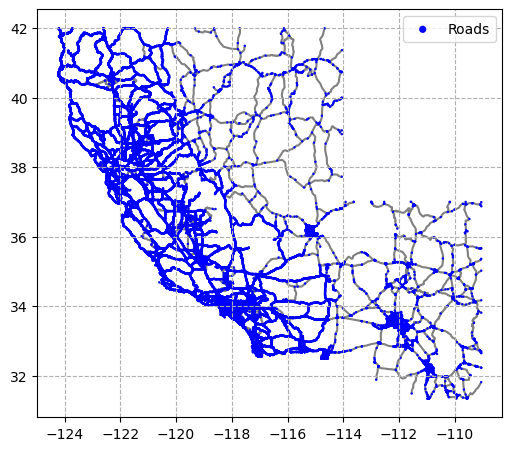

In [69]:
deep_reload(src)

fig, ax = plt.subplots(1, 1, figsize = (6, 6), squeeze = False)

kwargs = {
		'node_field': None,
		'scatter': {
			's': 3,
			'ec': 'none',
            'fc': 'b',
            'label': 'Roads',
		},
		'show_links': False,
	}

gdf_select.plot(ax = ax[0, 0], ec = 'gray', fc = 'none', zorder = 0)
src.figures.plot_graph(graph, ax = ax[0, 0], **kwargs)
ax[0, 0].legend(markerscale = 3)
ax[0, 0].grid(ls = '--')

# fig.savefig('Document/figs/California_Places_Chargers', bbox_inches = 'tight', dpi = 300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


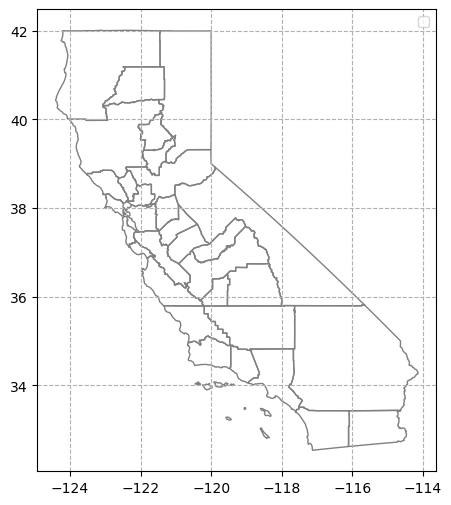

In [74]:
deep_reload(src)

fig, ax = plt.subplots(1, 1, figsize = (6, 6), squeeze = False)

kwargs = {
		'node_field': None,
		'scatter': {
			's': 3,
			'ec': 'none',
            'fc': 'b',
            'label': 'Roads',
		},
		'show_links': False,
	}

gdf_zones_california.plot(ax = ax[0, 0], ec = 'gray', fc = 'none', zorder = 0)
# src.figures.plot_graph(graph, ax = ax[0, 0], **kwargs)
ax[0, 0].legend(markerscale = 3)
ax[0, 0].grid(ls = '--')

# fig.savefig('Document/figs/California_Places_Chargers', bbox_inches = 'tight', dpi = 300)